In [1]:
import open3d as o3d
import open3d.core as o3c

if o3d.__DEVICE_API__ == 'cuda':
    import open3d.cuda.pybind.t.pipelines.registration as treg
else:
    import open3d.cpu.pybind.t.pipelines.registration as treg

import numpy as np
import sys
import os
import time

# monkey patches visualization and provides helpers to load geometries
sys.path.append('..')
import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
o3dtut.interactive = not "CI" in os.environ

[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/RGBD/normal_map.npy already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/RGBD/raycast_vtx_004.npy already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/bunnyData.pts already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample1.pts already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/point_cloud_sample2.pts already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/tests/cube.obj already exists, skipped.
[download_utils.py] /home/rey/workspace/isl/clean/Open3D/examples/test_data/open3d_downloads/RGBD/vertex_map.npy already exists, skipped.


# Robust Kernel

This tutorial demonstrates the use of robust kernels in the context of outlier rejection. For this particular tutorial, we will be using the ICP (Iterative Closest Point) registration algorithm as the _target_ problem where we want to deal with outliers. Even so, the theory applies to any given optimization problem and not just for ICP. For the moment the robust kernels have been only implemented for the `PointToPlane` ICP.

The notation and some of the kernels implemented in `Open3D` has been inspired by the publication "Analysis of Robust Functions for Registration Algorithms" [\[Babin2019\]](../reference.html#babin2019)

## Point-to-plane ICP using Robust Kernels

The standard point-to-plane ICP algorithm [\[ChenAndMedioni1992\]](../reference.html#chenandmedioni1992) minimizes this objective function:

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2},
\end{equation}

where $\mathbf{n}_{\mathbf{p}}$ is the normal of point $\mathbf{p}$ and $\mathcal{K}$ is the correspondence set between the target point cloud $\mathbf{P}$, and source point cloud $\mathbf{Q}$.

If we call $r_i(\mathbf{T})$ is $i^\mathrm{th}$ the residual, for a given pair of correspondences $(\mathbf{p},\mathbf{q})\in\mathcal{K}$ we can rewrite the objective function as.

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big)^{2} = \sum_{i=1}^{N} \big({r_i(\mathbf{T})}\big)^2
\end{equation}

The optimization problem above can also be solved by using the iteratively reweighted least-squares (IRLS) approach, which solves a sequence of weighted least squares problems:

\begin{equation}
E(\mathbf{T}) =  \sum_{i=1}^{N} w_i \big({r_i(\mathbf{T})}\big)^2
\end{equation}

### Outlier Rejection with Robust Kernels

The main idea of a robust loss is to downweight large residuals that are assumed to be caused from outliers such that their influence on the solution is reduced. This is achieved by optimizing $E(\mathbf{T})$ as:

\begin{equation}
E(\mathbf{T}) = \sum_{(\mathbf{p},\mathbf{q})\in\mathcal{K}}\rho\big((\mathbf{p} - \mathbf{T}\mathbf{q})\cdot\mathbf{n}_{\mathbf{p}}\big) = \sum_{i=1}^{N} \rho\big({r_i(\mathbf{T})}\big),
\end{equation}

where $\rho(r)$ is also called the robust loss or kernel.

We can see that exists a relation between the optimization formulation in IRLS and the one that uses the robust loss function. By setting the weight $w_i= \frac{1}{r_i(\mathbf{T})}\rho'(r_i(\mathbf{T}))$, we can solve the robust loss optimization problem using the existing techniques for weighted least-squares. Therefore, we can minimize the objective function using Gauss-Newton and determine increments by iteratively solving:

\begin{align}
\left(\mathbf{J}^\top \mathbf{W} \mathbf{J}\right)^{-1}\mathbf{J}^\top\mathbf{W}\vec{r},
\end{align}

where $\mathbf{W} \in \mathbb{R}^{N\times N}$ is a diagonal matrix containing weights $w_i$ for each residual $r_i$

### How to use Robust Kernels in Open3D

`icp`, `multi_scale_icp` can be called with a parameter `TransformationEstimationPointToPlane(loss)` or `TransformationEstimationForColoredICP(loss)`. Where `loss` is a given loss function(also called robust kernel). 

Internally, `TransormationEstimationPointToPlane(loss)` implements a function to compute the weighted residuals and Jacobian matrices of the point-to-plane ICP objective according to the provided robust kernel.

## Vanilla ICP vs Robust ICP

To better show the advantages of using robust kernels in the registration, we add some artificially generated gaussian noise to the source point cloud.

In [2]:
# Overriding visualization function, according to best camera view for colored-icp sample data.
def draw_registration_result(source, target, transformation):
    source_temp = source.clone()
    target_temp = target.clone()

    source_temp.transform(transformation)

    # This is patched version for tutorial rendering.
    # Use `draw` function for you application.
    o3d.visualization.draw_geometries(
        [source_temp.to_legacy(),
         target_temp.to_legacy()],
        zoom=0.4459,
        front=[0.9288, -0.2951, -0.2242],
        lookat=[1.6784, 2.0612, 1.4451],
        up=[-0.3402, -0.9189, -0.1996])

In [3]:
source = o3d.t.io.read_point_cloud("../../test_data/ICP/cloud_bin_0.pcd")
target = o3d.t.io.read_point_cloud("../../test_data/ICP/cloud_bin_1.pcd")

Source PointCloud + noise:


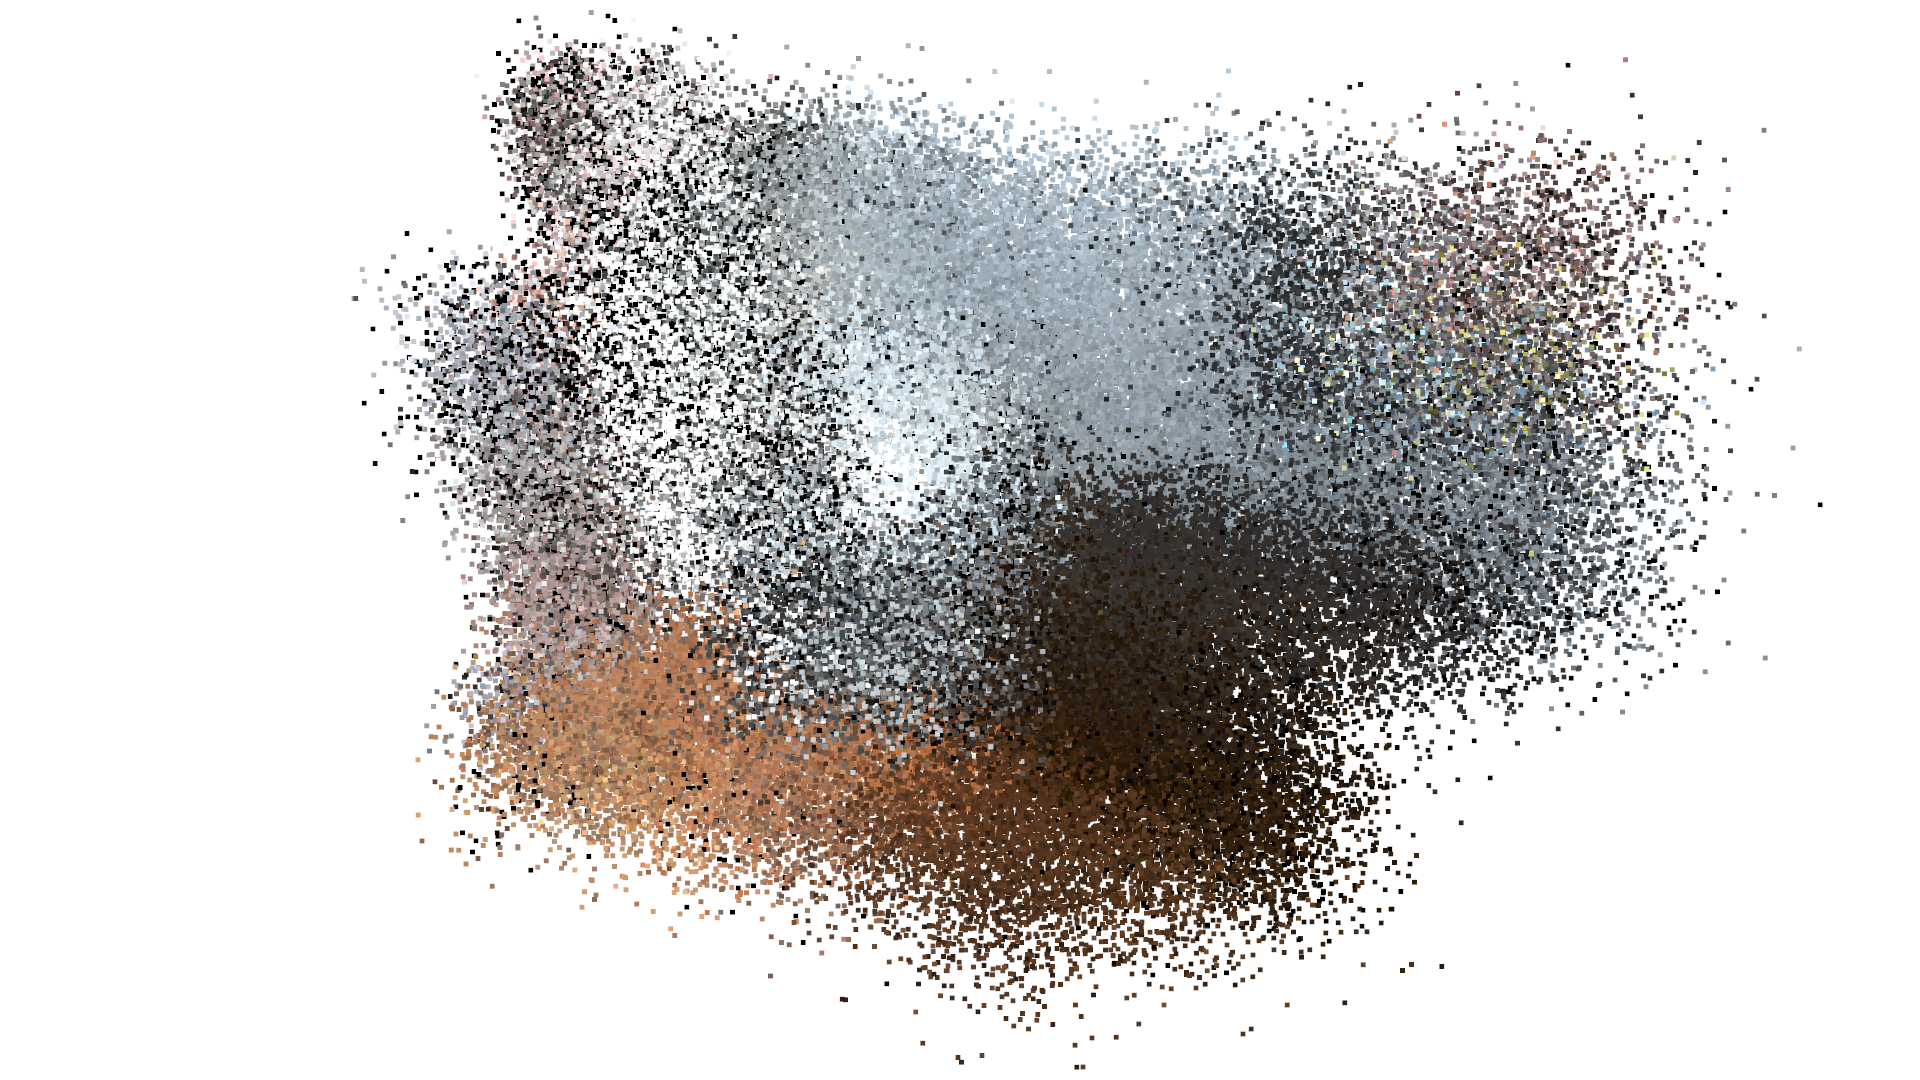

In [4]:
def apply_noise(pcd, mu, sigma):
    device = pcd.point["positions"].device
    noisy_pcd = pcd.cpu().clone()
    noisy_pcd.point["positions"] += o3d.core.Tensor(
        np.random.normal(mu, sigma, size=noisy_pcd.point["positions"].shape),
        noisy_pcd.point["positions"].dtype)
    return noisy_pcd


mu, sigma = 0, 0.1  # mean and standard deviation
source_noisy = apply_noise(source, mu, sigma)

print("Source PointCloud + noise:")
o3d.visualization.draw_geometries([source_noisy.to_legacy()],
                                  zoom=0.4459,
                                  front=[0.353, -0.469, -0.809],
                                  lookat=[2.343, 2.217, 1.809],
                                  up=[-0.097, -0.879, 0.467])

### Vanilla ICP

We inspect how the results will look if we use the exact same parameters that were used in the above examples of ICP.

In [5]:
# Initial alignment or source to target transform.
init_source_to_target = np.asarray([[0.862, 0.011, -0.507, 0.5],
                                    [-0.139, 0.967, -0.215, 0.7],
                                    [0.487, 0.255, 0.835, -1.4],
                                    [0.0, 0.0, 0.0, 1.0]])

criteria = treg.ICPConvergenceCriteria(relative_fitness=0.000001,
                                       relative_rmse=0.000001,
                                       max_iteration=50)

In [6]:
estimation = treg.TransformationEstimationPointToPlane()

In [7]:
max_correspondence_distance = 0.02

Vanilla point-to-plane ICP, max_correspondence_distance=0.02:
Time taken by Point-To-Plane ICP:  0.4032137393951416
Fitness:  0.09779968315437423
Inlier RMSE:  0.011979085346772868


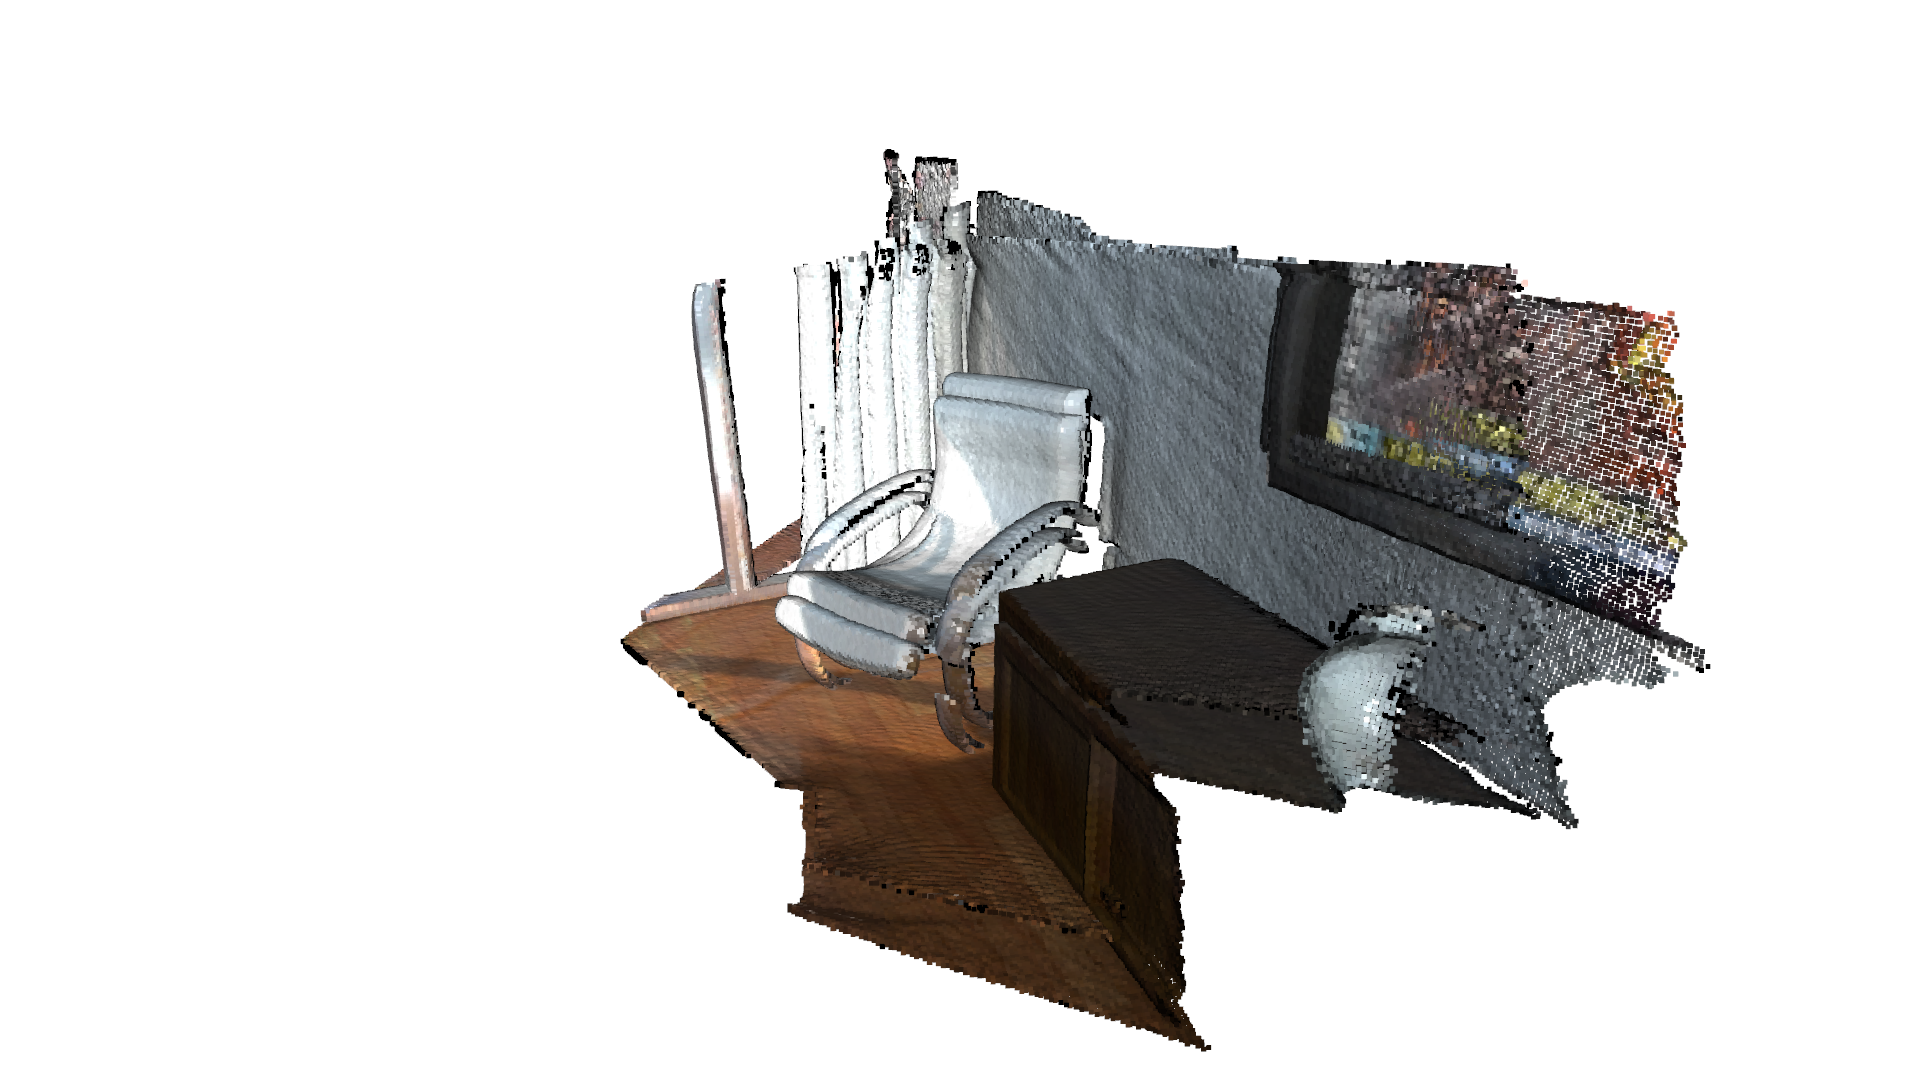

In [8]:
print("Vanilla point-to-plane ICP, max_correspondence_distance={}:".format(
    max_correspondence_distance))
s = time.time()

reg_point_to_plane = treg.icp(source_noisy, target, max_correspondence_distance,
                              init_source_to_target, estimation)

icp_time = time.time() - s

print("Time taken by Point-To-Plane ICP: ", icp_time)
print("Fitness: ", reg_point_to_plane.fitness)
print("Inlier RMSE: ", reg_point_to_plane.inlier_rmse)

draw_registration_result(source, target, reg_point_to_plane.transformation)

### Tuning Vanilla ICP

Given the fact that we are now dealing with gaussian noise, we might try to increase the threshold to search for nearest neighbors with the aim of improving the registration result.

We can see that under these condtions and without a robust kernel, the traditional ICP has no chance to deal with  outliers.

In [9]:
estimation = treg.TransformationEstimationPointToPlane()

In [10]:
max_correspondence_distance = 0.5

voxel_size = 0.02

Vanilla point-to-plane ICP, max_correspondence_distance=0.5:
Time taken by Point-To-Plane ICP:  8.795312404632568
Fitness:  0.839519329707482
Inlier RMSE:  0.1396766495248722


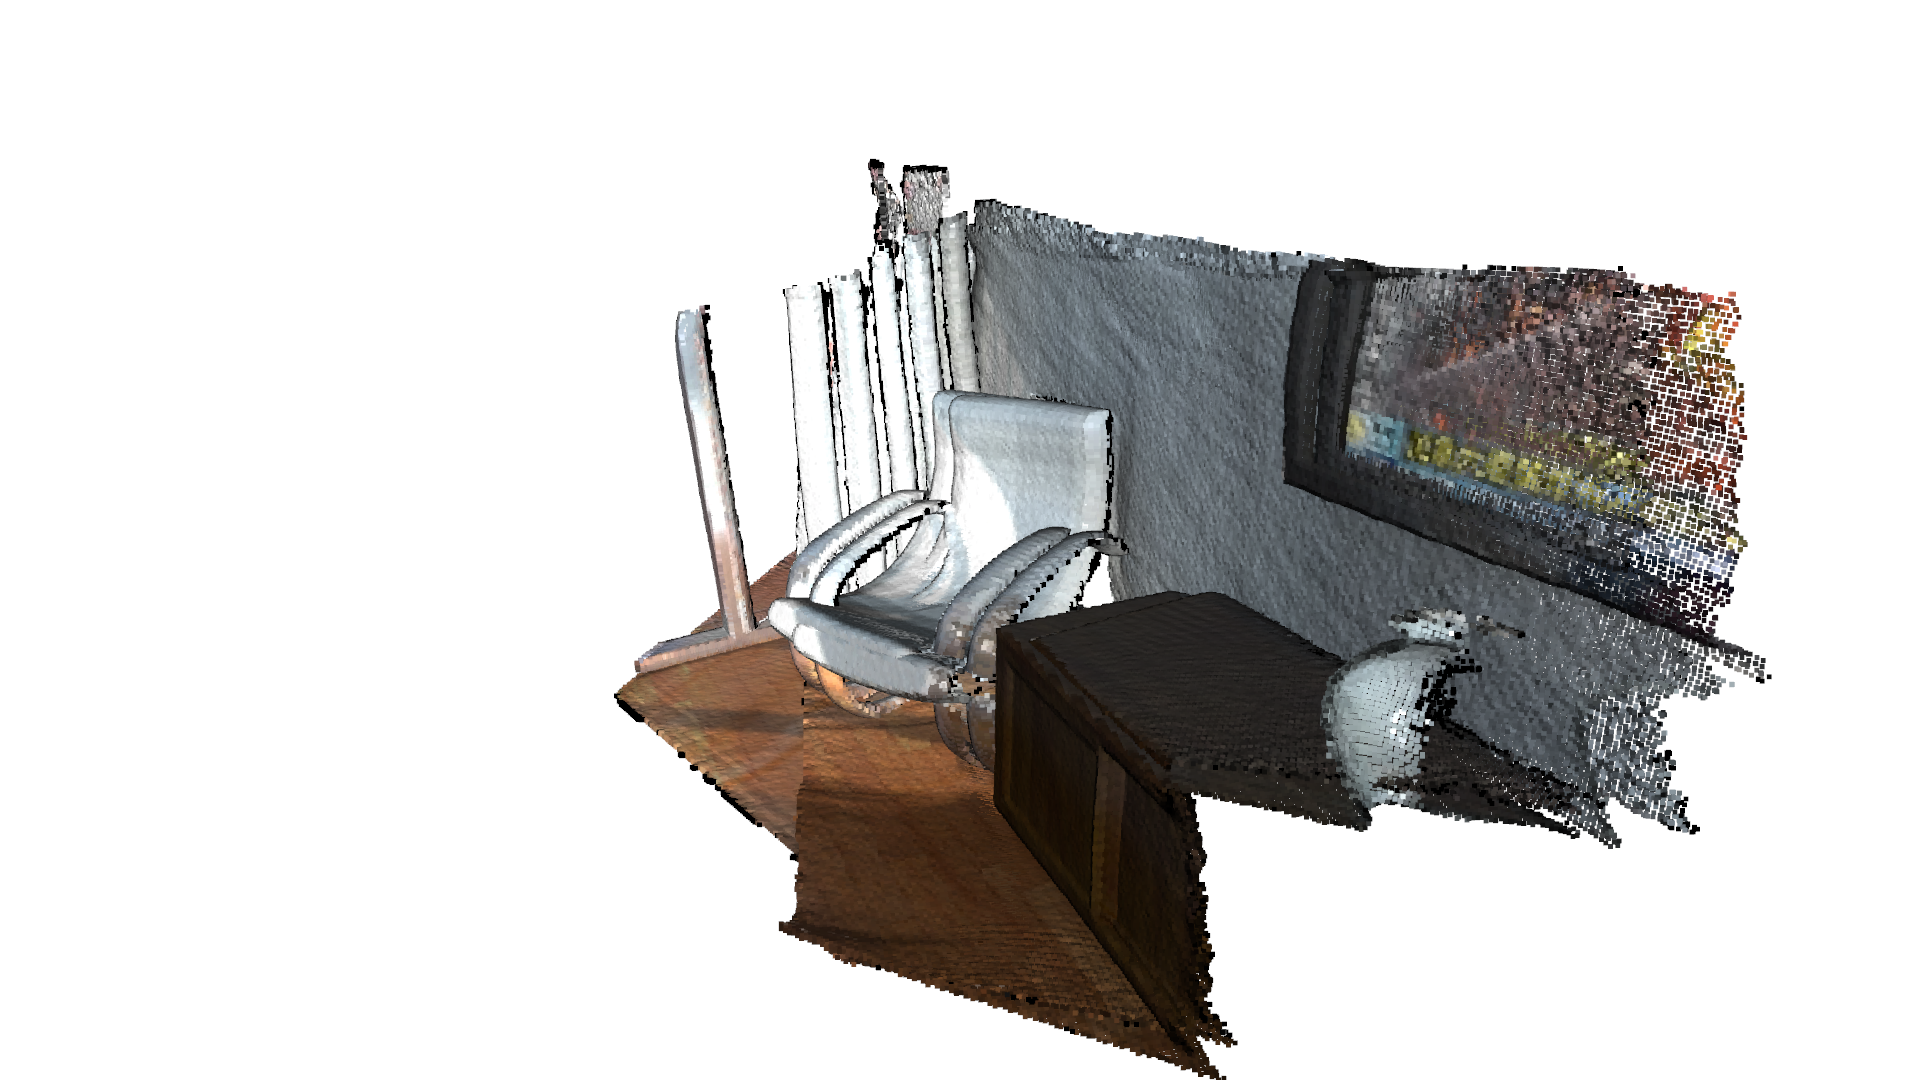

In [11]:
print("Vanilla point-to-plane ICP, max_correspondence_distance={}:".format(
    max_correspondence_distance))

s = time.time()

reg_point_to_plane = treg.icp(source, target, max_correspondence_distance,
                              init_source_to_target, estimation, criteria,
                              voxel_size)

icp_time = time.time() - s

print("Time taken by Point-To-Plane ICP: ", icp_time)
print("Fitness: ", reg_point_to_plane.fitness)
print("Inlier RMSE: ", reg_point_to_plane.inlier_rmse)

draw_registration_result(source, target, reg_point_to_plane.transformation)

### Robust ICP

Using the same `max_correspondence_distance=0.5` **and** a robust kernel, we can properly register the two point clouds:

In [12]:
mu, sigma = 0, 0.1  # mean and standard deviation
estimation = treg.TransformationEstimationPointToPlane(
    treg.robust_kernel.RobustKernel(
        treg.robust_kernel.RobustKernelMethod.TukeyLoss, sigma))

Vanilla point-to-plane ICP, max_correspondence_distance=0.5:
Time taken by Point-To-Plane ICP:  3.8376433849334717
Fitness:  0.8133544024694987
Inlier RMSE:  0.133775086059949


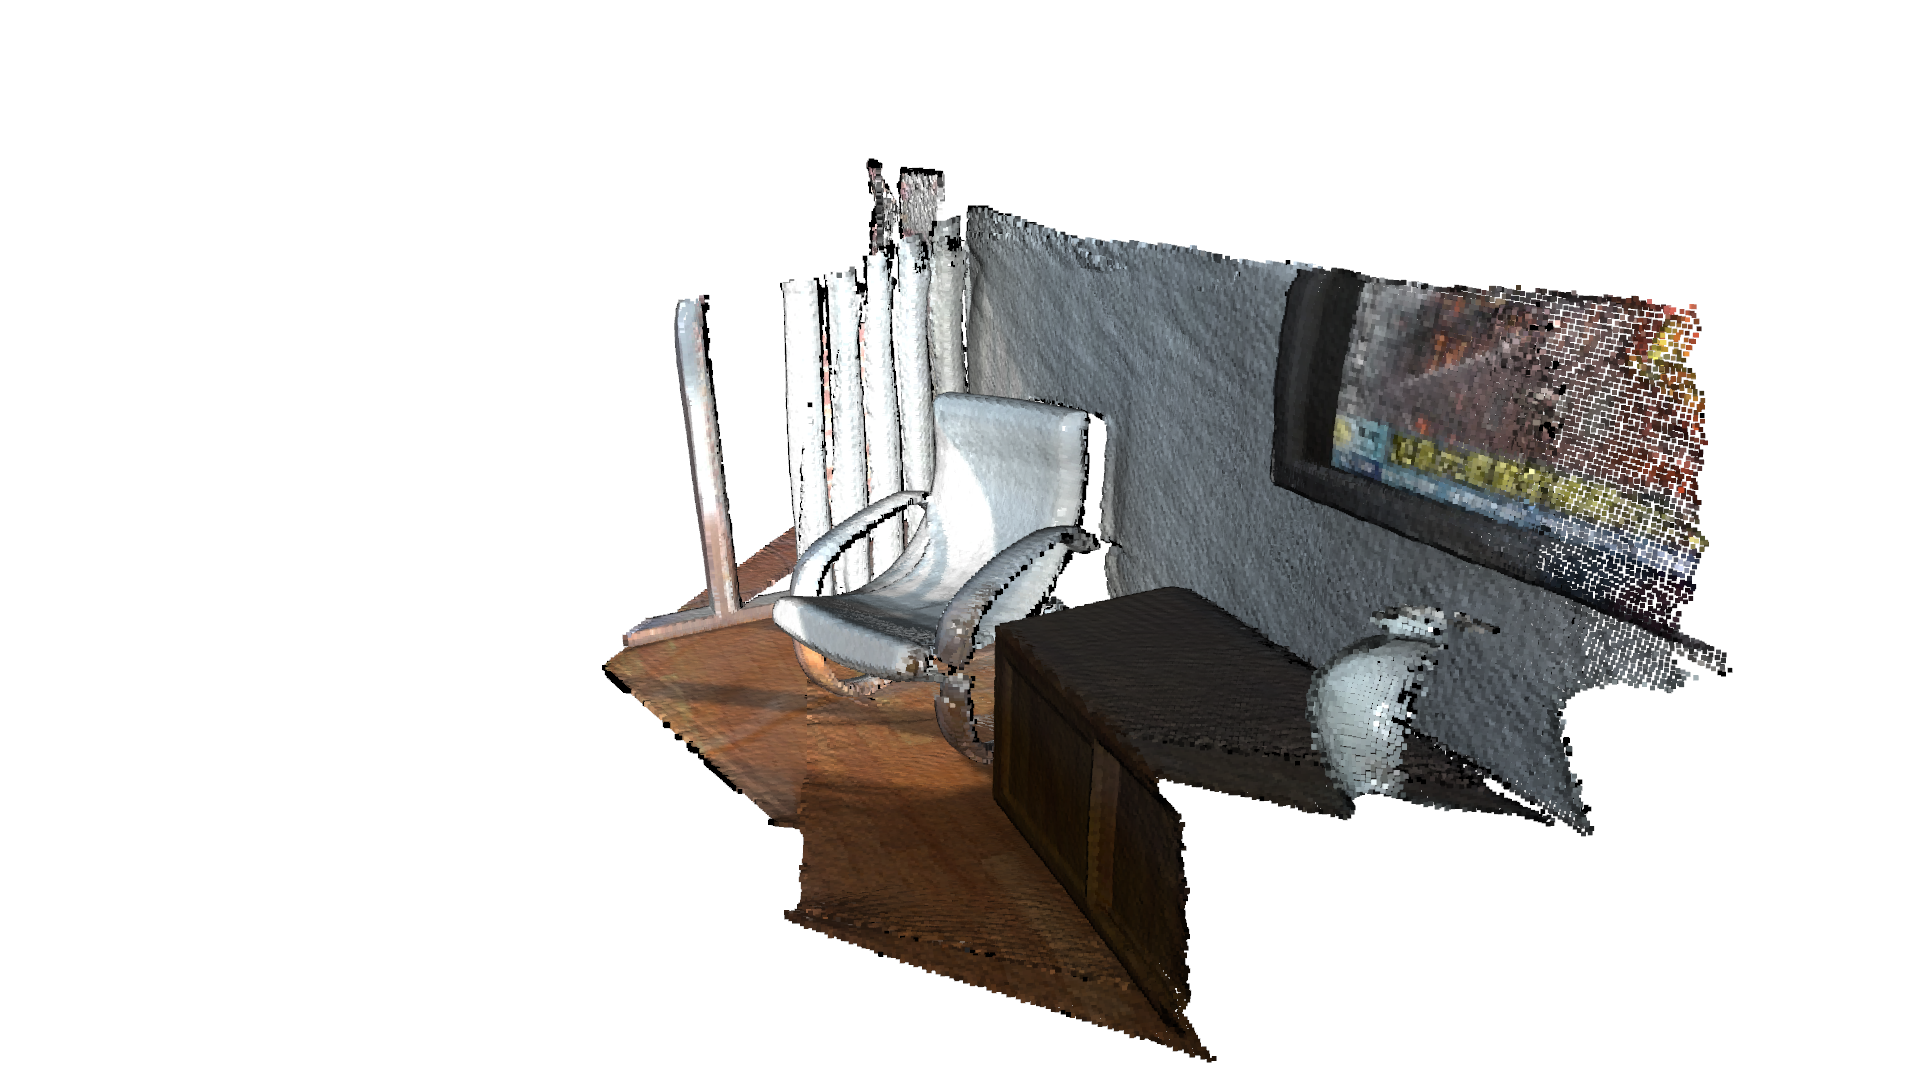

In [13]:
print("Vanilla point-to-plane ICP, max_correspondence_distance={}:".format(
    max_correspondence_distance))

s = time.time()

reg_point_to_plane = treg.icp(source, target, max_correspondence_distance,
                              init_source_to_target, estimation, criteria,
                              voxel_size)

icp_time = time.time() - s
print("Time taken by Point-To-Plane ICP: ", icp_time)
print("Fitness: ", reg_point_to_plane.fitness)
print("Inlier RMSE: ", reg_point_to_plane.inlier_rmse)

draw_registration_result(source, target, reg_point_to_plane.transformation)

Registration estimation method supports `Robust Kernels`:

`robust_kernel = o3d.t.pipelines.registration.robust_kernel.RobustKernel(method, scale, shape)`

Method options:

- robust_kernel.RobustKernelMethod.L2Loss
- robust_kernel.RobustKernelMethod.L1Loss
- robust_kernel.RobustKernelMethod.HuberLoss
- robust_kernel.RobustKernelMethod.CauchyLoss
- robust_kernel.RobustKernelMethod.GMLoss
- robust_kernel.RobustKernelMethod.TukeyLoss
- robust_kernel.RobustKernelMethod.GeneralizedLoss

<div class="alert alert-info">
    
**Note:** 

For this example we use the **TukeyLoss**. For the parameter `k` we set it to match the std deviation of the noise model $k = \sigma$.
The parameter `k` used in the Robust Kernels it's usually pick to match the standard deviation of the noise model of the input data. In this sense, `k`, is the discriminator between **inlier**/**outlier**. Altough this is not always trivial to define in real world data, for synthetic one, it's easy to fix in order to illustrate the benefits of the robust kernels.
 
</div>

---